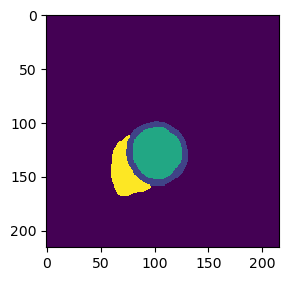

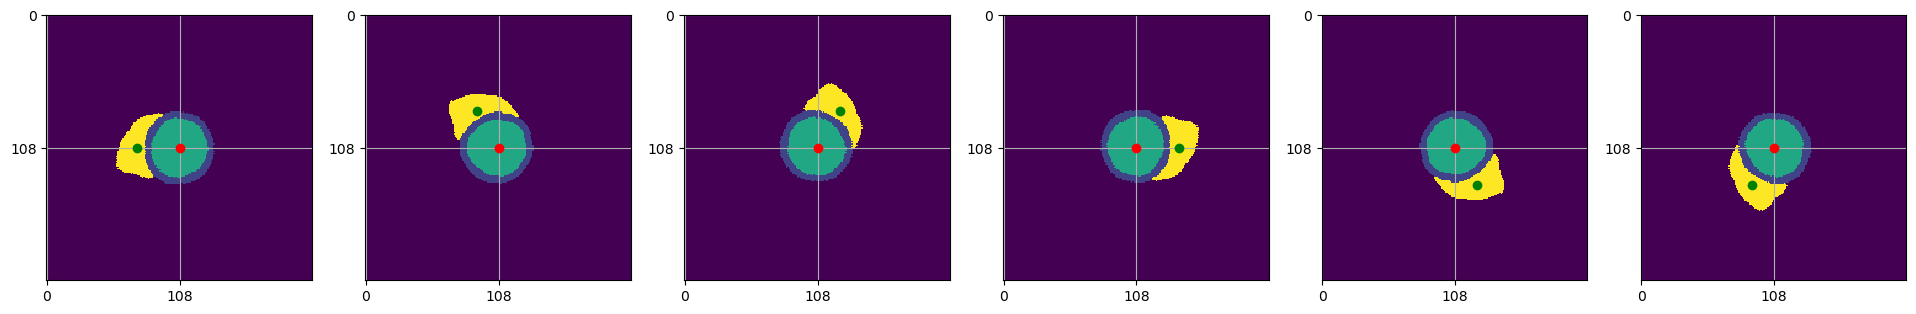

In [48]:
import Datapreprocess as dp
import numpy as np
import nibabel as nib
import torch
import torch.nn.functional as F 
from pathmanager import segpatient_split_path, segment_path_trimmed, seg_raw_files_path
import matplotlib.pyplot as plt
from IPython import display
import Parser 

seg_image_n = dp.nii2tensor(segment_path_trimmed[3])[3]#segmented slice at frame 3
seg_image_n = seg_image_n[:216,:216].unsqueeze(0).unsqueeze(0)
fig = plt.figure(figsize=[3.,4.])
plt.imshow(seg_image_n.squeeze().T)
plt.show()
plt.close(fig)


    
vox_lv_origin = dp.get_origin_from_label(label=seg_image_n, class_idx = dp.label_dict['Left_Ventricle'])
vox_rv_origin = dp.get_origin_from_label(label=seg_image_n, class_idx = dp.label_dict['Right_Ventricle'])
gs_translation_vect = dp.get_grid_sample_coord_from_vox(vox_lv_origin, seg_image_n.shape)

lv_to_rv_vect = vox_rv_origin - vox_lv_origin
lv_rv_base_angle = torch.atan2(lv_to_rv_vect[1], lv_to_rv_vect[0])/np.pi*180 + 90 

fig, axes = plt.subplots(1,6,figsize=[24.,4.])
for angle_idx, angle in enumerate(torch.linspace(0,300,6)+lv_rv_base_angle):

    rot_mat_2d = dp.rotation_matrix(angle)
    move_lv_affine = dp.get_affine_from_rt(rot_mat_2d, gs_translation_vect).unsqueeze(0).float()
    
    centered_lv_label = dp.spatialtransformer(seg_image_n, move_lv_affine[:,:2,:])

    gs_rv_origin = dp.get_grid_sample_coord_from_vox(vox_rv_origin, seg_image_n.shape)
    gs_rv_origin_moved = move_lv_affine.inverse() @ torch.cat([gs_rv_origin, torch.tensor([1])])
    vox_rv_origin_moved = dp.get_vox_from_grid_sample_coord(gs_rv_origin_moved.view(3)[:2], seg_image_n.shape)
    vox_rv_origin_moved = vox_rv_origin_moved.round().int()
    
    show_label = centered_lv_label.transpose(-2,-1)
    axes[angle_idx].plot(216//2, 216//2, marker='o', color="red")
    axes[angle_idx].plot(vox_rv_origin_moved[1], vox_rv_origin_moved[0], marker='o', color="green")
    axes[angle_idx].grid()
    axes[angle_idx].set_xticks(np.arange(0,217,108))
    axes[angle_idx].set_yticks(np.arange(0,217,108))
    axes[angle_idx].imshow(show_label.squeeze(), interpolation='none')

plt.show()
plt.close(fig)

### Data Analysis
To check the distribution of data in the temporal and spatial axis. 
Inorder to generate the time series data, we need information regarding the deformation of keypoints from ES - ED. By roughly looking at the data this varies with patients. Further, the size of some images are also differant than the others. Therefore a detailed analysis is required.

In [49]:
dataset_shape = []
for file in seg_raw_files_path:
    dataset_shape.append(torch.as_tensor(dp.nii2tensor(file).shape))
    
    

torch.Size([100, 4])


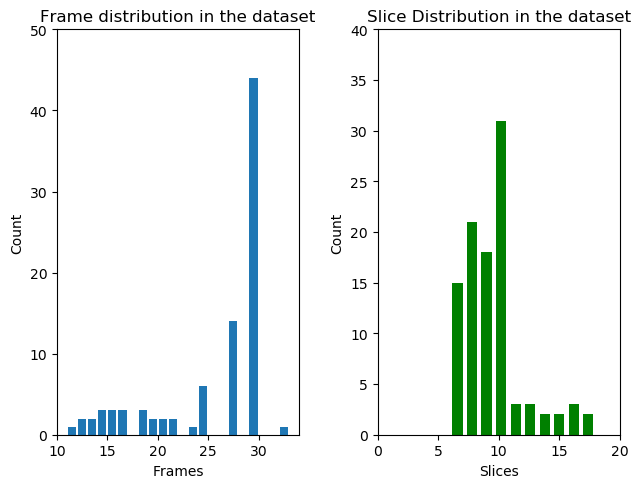

....Summary....
Maximum number of frames in the set is 34
Minimum number of frames in the set is 11
Maximum number of slices encountered in a single image from the set is 18
Minimum number of slices encountered in a single image from the set is 6


In [108]:
shape_tensor = torch.stack(dataset_shape)
print(shape_tensor.shape)
max_values, max_indices = torch.max(shape_tensor, dim = 0)
min_values, min_indices = torch.min(shape_tensor, dim = 0)

T_max, D_max, H_max, W_max = max_values
T_min, D_min, H_min, W_min = min_values
fig, [ax1, ax2] = plt.subplots(1,2)
ax1.hist(shape_tensor[:,0], bins = range(10,34), rwidth= 0.8)
ax1.set_title('Frame distribution in the dataset')
ax1.set_xlabel('Frames')
ax1.set_xlim(10, 34)
ax1.set_ylim(0, 50)
ax1.set_ylabel('Count')

ax2.hist(shape_tensor[:,1], rwidth= 0.7, color = 'green')
ax2.set_title('Slice Distribution in the dataset')
ax2.set_xlabel('Slices')
ax2.set_xlim(0, 20)
ax2.set_ylim(0, 40)
ax2.set_ylabel('Count')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

print("....Summary....")
print("Maximum number of frames in the set is {}".format(int(T_max)))
print("Minimum number of frames in the set is {}".format(int(T_min)))
print("Maximum number of slices encountered in a single image from the set is {}".format(int(D_max)))
print("Minimum number of slices encountered in a single image from the set is {}".format(int(D_min)))
